# Flood Prediction Model 2 - Hourly Discharge at multiple basins

The Objective of this notebook is to create a flood prediction model for multiple basins. We will use hourly rainfall data and an hourly discharge as the target time series and a single hourly rainfall time series as input variable for multiple basins. Training multiple timeseries data on the same networks makes DeepAR more effective. This model will be used for comparision with [RORB](https://www.monash.edu/engineering/departments/civil/research/themes/water/rorb)’s predictions.

## Benchmark Model

[RORB](https://www.monash.edu/engineering/departments/civil/research/themes/water/rorb) model is generally employed for calculating design flood discharges. It uses many assumptions and is manually calibrated to one flooding event. This will be used as benchmark model for comparison purpose.

## Data Set
The hydrological data available at [Queensland Water Monitoring Information Portal](https://water-monitoring.information.qld.gov.au/) will be used. Hourly as well as daily water flow data is available at various stations. Rainfall data is available in some of the stations. For the Caboolture River, only single discharge and rainfal station is available. 



### Work Workflow

* Preprocessing and exploring the data
* Creating training and test sets of time series
* Formatting data as JSON files and uploading to S3
* Instantiating and training a DeepAR estimator
* Deploying a model and creating a predictor
* Comparing the Predictor with RORB's performance

# Preprocessing and exploring the data

The raw data for Caboolture River is available at raw_data/Caboolture folder. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

from utility import unzip_ts_data, read_ts_data, series_to_json, clean_ts_data, write_json_dataset


In [2]:
# Read target (flow) and feature (rain) data

# Unzip the data and get list of csv paths
cabooltre_csv_paths = unzip_ts_data('./raw_data/Caboolture')
maroochy_csv_paths = unzip_ts_data('./raw_data/Maroochy')
burdekin_csv_paths = unzip_ts_data('./raw_data/Burdekin/Streamflow')

all_csv_paths = cabooltre_csv_paths + maroochy_csv_paths + burdekin_csv_paths


        


./raw_data/Caboolture/142001A_20191103_rain
unzipped 142001A_20191103_rain.zip!
./raw_data/Caboolture/142001A_20191103_flow
unzipped 142001A_20191103_flow.zip!
./raw_data/Maroochy/141004B_20191110_rain
unzipped 141004B_20191110_rain.zip!
./raw_data/Maroochy/141004B_20200131_flow
unzipped 141004B_20200131_flow.zip!
./raw_data/Burdekin/Streamflow/120207A_20191103_flow
unzipped 120207A_20191103_flow.zip!
./raw_data/Burdekin/Streamflow/120106B_20191103_rain
unzipped 120106B_20191103_rain.zip!
./raw_data/Burdekin/Streamflow/120112A_20191103_rain
unzipped 120112A_20191103_rain.zip!
./raw_data/Burdekin/Streamflow/120107B_20191103_rain
unzipped 120107B_20191103_rain.zip!
./raw_data/Burdekin/Streamflow/120207A_20191103_rain
unzipped 120207A_20191103_rain.zip!
./raw_data/Burdekin/Streamflow/120102A_20191103_flow
unzipped 120102A_20191103_flow.zip!
./raw_data/Burdekin/Streamflow/120112A_20191103_flow
unzipped 120112A_20191103_flow.zip!
./raw_data/Burdekin/Streamflow/120110A_20191103_flow
unzipped

In [3]:
import re

# Loop through each path and extract the station and data type (rain vs flow), and store in a dictioinary

all_stn_data = {}
for csv_path in all_csv_paths:
    stn_name = re.search(r"/([A-Z0-9]*).csv", csv_path).group(1)
    # create station dictionary if it doesn't exist
    if stn_name not in all_stn_data:
        all_stn_data[stn_name] = {}
    # Read appropriate data 
    if re.search(r"_flow/", csv_path):
        all_stn_data[stn_name]["flow"] = csv_path
    elif re.search(r"_rain/", csv_path):
        all_stn_data[stn_name]["rain"] = csv_path
        

for key, stn in all_stn_data.items():
    if len(stn) < 2:
        del all_stn_data[key]



In [4]:
prediction_length = 24

# save this data to a local directory
data_dir = 'model2_json_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# directories to save train/test data
train_path = os.path.join(data_dir, 'train.json')
test_path = os.path.join(data_dir, 'test.json')
val_path = os.path.join(data_dir, 'val.json')

if os.path.isfile(train_path):
    os.remove(train_path)
    
if os.path.isfile(test_path):
    os.remove(test_path)

for cat, (key, stn) in enumerate(all_stn_data.items()):
    # Update category number (index)
    stn["cat"] = cat
    # Read flow and rain data
    target_ts_data = read_ts_data(stn["flow"], value_cols = ["Mean"], prefix = "flow")
    rain_ts_data = read_ts_data(stn["rain"], value_cols = ["Total"], prefix = "rain")
    # join both the data
    main_ts_data = target_ts_data.join(rain_ts_data)
    # Clean the data
    ts_s = clean_ts_data(main_ts_data, datetime.timedelta(hours=1), 5*prediction_length)
    
    # Split data into training and test set
    ts_train = []
    ts_test = []
    for ts in ts_s:
        if ts.index[0] <= pd.Timestamp('2005-01-01 00:00:00'):
            ts_train.append(ts)
        else:
            ts_test.append(ts)
    # Save the test data in the dictionary
    stn["ts_test"] = ts_test
    
    # Write test and train data to json file
    write_json_dataset(ts_train, "flowMean", train_path, cat = cat)        
    write_json_dataset(ts_test, "flowMean", test_path, cat = cat)
    print(key)
    

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


model2_json_data/train.json saved.
model2_json_data/test.json saved.
142001A
model2_json_data/train.json saved.
model2_json_data/test.json saved.
141004B
model2_json_data/train.json saved.
model2_json_data/test.json saved.
120207A
model2_json_data/train.json saved.
model2_json_data/test.json saved.
120106B
model2_json_data/train.json saved.
model2_json_data/test.json saved.
120112A
model2_json_data/train.json saved.
model2_json_data/test.json saved.
120107B
model2_json_data/train.json saved.
model2_json_data/test.json saved.
120102A
model2_json_data/train.json saved.
model2_json_data/test.json saved.
120110A
model2_json_data/train.json saved.
model2_json_data/test.json saved.
120205A


# Uploading data to S3



In [5]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [6]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()

prefix='flood-prediction-multiple-basin'

Upload training data to a location in S3, and save that location to train_path
Upload test data to a location in S3, and save that location to test_path

In [7]:


# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_s3_path  = sagemaker_session.upload_data(train_path, bucket=bucket, key_prefix=train_prefix)
test_s3_path   = sagemaker_session.upload_data(test_path,  bucket=bucket, key_prefix=test_prefix)

In [9]:
# check locations
print('Training data is stored in: '+ train_s3_path)
print('Test data is stored in: '+ test_s3_path)

Training data is stored in: s3://sagemaker-ap-southeast-2-990878777707/flood-prediction-multiple-basin/train/train.json
Test data is stored in: s3://sagemaker-ap-southeast-2-990878777707/flood-prediction-multiple-basin/test/test.json


---
# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [10]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


### Instantiate an Estimator 

You can now define the estimator that will launch the training job. A generic Estimator will be defined by the usual constructor arguments and an `image_name`. 
> You can take a look at the [estimator source code](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/estimator.py#L595) to view specifics.


In [11]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      output_path=s3_output_path
                      )


## Setting Hyperparameters

Next, we need to define some DeepAR hyperparameters that define the model size and training behavior. Values for the epochs, frequency, prediction length, and context length are required.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

### Context Length

Typically, it is recommended that you start with a `context_length`=`prediction_length`. This is because a DeepAR model also receives "lagged" inputs from the target time series, which allow the model to capture long-term dependencies. For example, a daily time series can have yearly seasonality and DeepAR automatically includes a lag of one year. So, the context length can be shorter than a year, and the model will still be able to capture this seasonality. 

The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are the previous week, 2 weeks, 3 weeks, 4 weeks, and year. You can read more about this in the [DeepAR "how it works" documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html).

### Optional Hyperparameters

You can also configure optional hyperparameters to further tune your model. These include parameters like the number of layers in our RNN model, the number of cells per layer, the likelihood function, and the training options, such as batch size and learning rate. 

For an exhaustive list of all the different DeepAR hyperparameters you can refer to the DeepAR [hyperparameter documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

## Training Job

Now, we are ready to launch the training job! SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the *actual* value of the time series. The computed error metrics will be included as part of the log output.

The next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

# Training the final model

In [12]:
freq='H'
context_length=24 # same as prediction_length

hyperparameters = {
    "epochs": "995",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "95",
    "num_layers": "7",
    "mini_batch_size": "74",
    "learning_rate": "0.0057",
    "dropout_rate" : "0.1"
}

In [13]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

In [ ]:
%%time
# train and test channels
data_channels = {
    "train": train_s3_path,
    "test": test_s3_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-01-31 15:02:46 Starting - Starting the training job...
2020-01-31 15:02:48 Starting - Launching requested ML instances......
2020-01-31 15:03:48 Starting - Preparing the instances for training...
2020-01-31 15:04:43 Downloading - Downloading input data..

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [ ]:
# %%time

# # create a predictor
# predictor = estimator.deploy(
#     initial_instance_count=1,
#     instance_type='ml.t2.medium',
#     content_type="application/json" # specify that it will accept/produce JSON
# )

-----------------------------------------------------------------------------------------

In [29]:
estimator._current_job_name

'forecasting-deepar-2020-01-28-11-50-19-637'

## Create endpoint from job name

In [30]:
job_name = "forecasting-deepar-200127-0636-011-a47b0ff3"

# job_name = estimator._current_job_name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

---------------------------------------------------------------------------!

In [23]:
# endpoint_name = "forecasting-deepar-2019-11-21-07-41-20-349"

In [31]:
import json 

class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length, target_col):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        self.target_col = target_col
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-self.prediction_length]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
#         instances = self.series_to_jsons(ts, self.target_col)
        json_objs = []
        for ts_i in ts:
            json_objs.append(series_to_json(ts_i, self.target_col, self.prediction_length))
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": json_objs, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df
    

In [32]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)


predictor.set_prediction_parameters(freq, prediction_length, target_col)

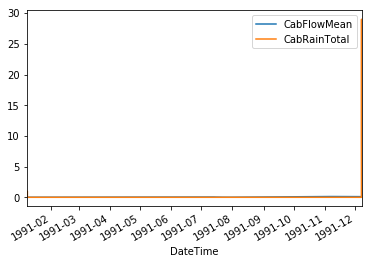

In [51]:
# CabFlowMean
# CabRainTotal
ts_s[1].plot()


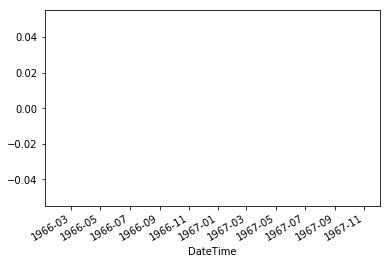

In [35]:
main_ts_data['CabRainTotal'][4400:12000].plot()

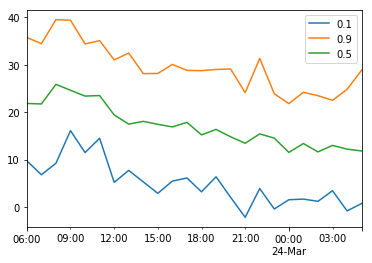

In [158]:
prediction_series[0].plot()

In [168]:
original_series = train_all_ts_data[4400:4505]
prediction_series = predictor.predict([original_series])



/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:32: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:50: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


In [169]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
#             target = target_ts[k][-prediction_length:]
            target_ts[k].plot(label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

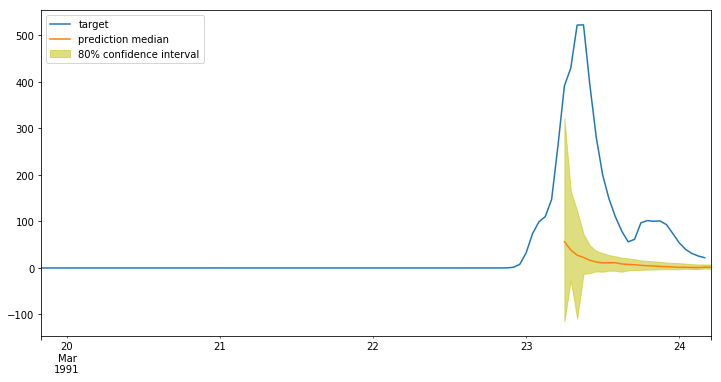

In [170]:
display_quantiles(prediction_series, target_ts=[original_series['CabFlowMean']])